In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm

%matplotlib inline

In [3]:
import matplotlib as mpl

In [4]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
from importlib import reload

In [6]:
import vehicleDetection.drawing
reload(vehicleDetection.drawing)

<module 'vehicleDetection.drawing' from '/mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/drawing.py'>

In [7]:
import vehicleDetection.temporal
reload(vehicleDetection.temporal)

<module 'vehicleDetection.temporal' from '/mnt/wdblue/Dropbox/Projects/Vehicle Detection/vehicleDetection/temporal.py'>

# Load and look at the training data.

In [8]:
images, classes = vehicleDetection.data.getData(numLighter=0, numFlip=0)
imageWindows = images
windowClasses = classes

HBox(children=(IntProgress(value=0, max=6726), HTML(value='')))

# Train the classifier on the full dataset with the best classifier parameters.

In [9]:
detectorNoAug = vehicleDetection.detector.Detector()

Got scalar parameter (C). Assuming no CV requested.


In [10]:
# indices = np.arange(len(images))
# np.random.shuffle(indices)
# # Fit time here is roughly linear in n.
# n = 1024
# imageWindows = [images[i] for i in indices[:n]]
# windowClasses = [classes[i] for i in indices[:n]]

In [11]:
spi = (3*60 + 59) / (6053 + 673)
print('Estimated fit/test runtime is %.3g minutes.' % (len(imageWindows) * spi / 60.,))

Estimated fit/test runtime is 3.98 minutes.


In [12]:
%%time
detectorNoAug.fit(
    imageWindows,
    windowClasses,
)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


6053-image train accuracy of clf =  0.99966958533
673-image test accuracy of clf =  0.994056463596
CPU times: user 2min 16s, sys: 596 ms, total: 2min 17s
Wall time: 2min 17s


# Run the detector on a test image.

In [ ]:
maxf = np.inf
testh = vehicleDetection.temporal.HeatVideo(maxFrames=maxf)

In [13]:
maxf = np.inf
projh = vehicleDetection.temporal.HeatVideo(fpath='../../../data/vehicleDetection/project_video.mp4', maxFrames=maxf)

In [ ]:
testh.go(detectorNoAug);

In [ ]:
# testh.coolingKwargs['heatTransferCoefficient'] = 1
# testh.coolingKwargs['heatCapacity'] = 6
# testh.coolingKwargs['powerFactor'] = 10
# testh.coolingKwargs['coolingRate'] = 64

In [ ]:
%%time
testh.persist(16)
testh.video();

In [ ]:
T = testh.temperatures[-1]
fig, ax = plt.subplots()
im = ax.imshow(T, origin='upper', cmap='hot')
fig.colorbar(im, label='temp [K]')

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(testh.vidFrame)
ax.set_xticks([])
ax.set_yticks([]);

In [ ]:
# projh.inputFrames = projh.inputFrames[120:]

In [ ]:
projh.go(detectorNoAug);

In [16]:
%%time
projh.persist(10)
projh.video();

HBox(children=(IntProgress(value=0, description='persist bboxes: ', max=274), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', description='project_video-detected.mp4: ', max=1), HTML(value='')))


CPU times: user 20.2 s, sys: 13.4 s, total: 33.6 s
Wall time: 53 s


Prototype an efficient pyramid of HOG features.

In [278]:
frame = projh.inputFrames[-1]
feature_image = detectorNoAug.featurize.getChannels(frame)
from skimage.feature import hog

In [279]:
d = 64
scales = [
        #  scale,    (lo,  hi),  overlap
           #(256/64, (720, 400), .5),
            (d/128, (690, 400), .5),
            (d/96,  (600, 400), .4),
            (d/64,  (600, 400), .3),
            (d/48,  (550, 400), .25),
        ]
hog_channel = 'ALL'
hog_channel = 0
orient = 9
pixels_per_cell = 8
cells_per_block = 2
hog_channels = [0, 1, 2] if str(hog_channel).lower() == 'all' else [hog_channel]

In [280]:
def ar(f):
    fr = round(f)
    assert f == fr
    return int(fr)

In [340]:
%%time


def breakIntoWindows(
    feature_channel,
    scales = [
        #  scale,    (lo,  hi),  overlap
           #(256/64, (720, 400), .5),
            (d/128, (690, 400), .5),
            (d/96,  (600, 400), .4),
            (d/64,  (600, 400), .3),
            (d/48,  (550, 400), .25),
        ],
    orient = 9,
    pixels_per_cell = 8,
    cells_per_block = 2,
    visualize=False,
    ):
    
    fl = np.math.floor
    
    # Accumulate output.
    blockWindows = []
    windowLocations = []
    sliceWindows = []
    hogVisualizations = []
    
    for islice in range(len(slices)):
        
        # Extract the image slice and goal window geometry.
        slice = slices[islice]
        scale, (lo, hi), overlapFraction = scales[islice]

        # Resize the image slice so that the windows will be d-by-d.
        unscaledSlice = feature_channel[hi:lo, :]
        sliceShape = tuple([int(s*scale) for s in unscaledSlice.shape[:2]])
        imgSlice = cv2.resize(unscaledSlice, sliceShape[::-1])
        
        # What is the geometry of a window and stride in the unscaled image?
        overlapPix = min(fl(d * overlapFraction), d - 1)
        stridePix = d - overlapPix
            
        # Extract HOG features for the scaled slice.
        res = hog(
            imgSlice[:, :],
            orientations=orient,
            pixels_per_cell=(pixels_per_cell, pixels_per_cell), 
            cells_per_block=(cells_per_block, cells_per_block),
            visualise=visualize, feature_vector=False
        )
        feature_array, hog_image = res if visualize else (res, None)

        # How do we convert from cell-&-block indexing to unscaled-pixel indexing?
        cellsPerWindow = ar(d / pixels_per_cell)
        
        # How does sklearn do the HOG block striding?
        overlappingBlocksPerWindow = cellsPerWindow - 1
        cellsPerBlockStride = 1
        
        # How many blocks should *we* step by so our windows overlap
        # by approximately the desired fraction?
        strideBlocks = round(stridePix / pixels_per_cell / cellsPerBlockStride)
        

        
#         for k in [
#             'imgSlice.shape', 'feature_array.shape', #'pixPerBlock', 'pixPerCell', 
#             'cellsPerWindow', 'overlappingBlocksPerWindow',
#             'overlapPix', 'stridePix', 'overlapFraction',
#             'strideBlocks',
#         ]:
#             pt(k)
        
        dr = dc = overlappingBlocksPerWindow
        rs = cs = strideBlocks
        
        
        def pt(expr, connector='is'):
            print(expr, connector, end=' ')
            exec('print(%s)' % expr)
        
        rpix = 0
        rl = 0
        while rl + dr <= feature_array.shape[0]:
            cl = 0
            cpix = 0
            while cl + dc <= feature_array.shape[1]:
                blockWindow = feature_array[rl:(rl+dr), cl:(cl+dc), ...]
                blockWindows.append(blockWindow)
                wl = np.floor(np.array((
                    (cpix / scale, hi + rpix / scale), ((cpix + d) / scale, hi + (rpix + d) / scale)
                ))).astype(int)
                windowLocations.append(tuple([tuple(p) for p in wl]))
                sliceWindows.append(
                    imgSlice[rpix:rpix+d, cpix:cpix+d]
                )
                if visualize:
                    hogVisualizations.append(
                        hog_image[rpix:rpix+d, cpix:cpix+d]
                    )
                cl += cs
                cpix += stridePix
            rl += rs
            rpix += stridePix
#         pt('np.stack(blockWindows).size')
#         pt('np.stack(sliceWindows).size')
#         print('--')
    return blockWindows, sliceWindows, windowLocations, hogVisualizations
blockWindows, sliceWindows, windowLocations, hogVisualizations = breakIntoWindows(feature_image[:, :, 1], visualize=True)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


CPU times: user 1.93 s, sys: 72 ms, total: 2 s
Wall time: 1.95 s


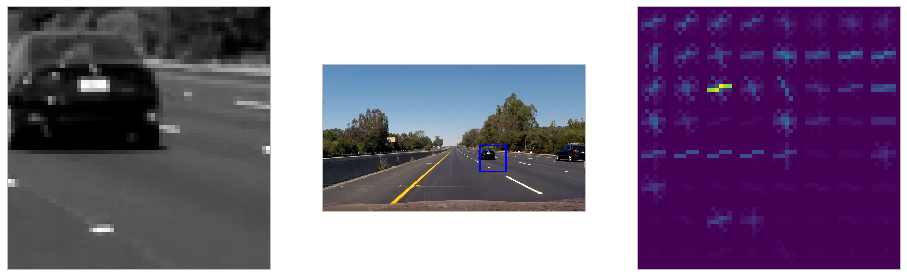

In [343]:
i = 12
im = sliceWindows[i]
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(16,9), ncols=3)
ax1.imshow(im, cmap='gray')
ax2.imshow(vehicleDetection.drawing.drawBboxes(frame, [windowLocations[i]]))
ax3.imshow(hogVisualizations[i])
for a in ax1, ax2, ax3:
    a.set_xticks([]); a.set_yticks([])

In [59]:
slice = slices[0]

In [61]:
feature_array = hog(slice[:, :, 0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=False)

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [62]:
feature_array.shape

(79, 17, 2, 2, 9)

Try again on the agumented data.

In [ ]:
images, classes = vehicleDetection.data.getData()

In [ ]:
detectorAug = vehicleDetection.detector.Detector()

In [ ]:
spi = (3*60 + 59) / (6053 + 673)
print('Estimated fit/test runtime is %.3g minutes.' % (len(images) * spi / 60.,))

In [ ]:
%%time
detectorAug.fit(
    images,
    classes,
)

In [ ]:
testha = HeatVideo()
testha.go(detectorAug)

In [ ]:
testha.persist(20)
testha.video(label='-augmented')

In [ ]:
projha = HeatVideo(fpath='../../../data/vehicleDetection/project_video.mp4',)
projha.go(detectorAug)

In [ ]:
projha.persist(20)
projha.video(label='-augmented')